In [1]:
# load modules
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.power import FTestAnovaPower, TTestIndPower, TTestPower
from pingouin import ttest, anova
import pingouin as pg
data_dir = 'plots_from_papers'

/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
# utility
def simulate_bar_graph_data(file, n_child, n_adult):
    """ 
    Utility function for pulling information from a bar 
    graph represented as a datafrane with 4 rows: 
        row 1 - mean child
        row 2 - mean + se (or sd) child
        row 3 - mean adult
        row 4 - mean + se (or sd) adult
    """
    tmp1 = pd.read_csv(file, header=None)
    tmp1.columns = ['dtype', 'value']
    tmp2 = pd.DataFrame({ 'group': ['child', 'adult'], 
                          'mean_val':[tmp1.value[0], tmp1.value[2]], 
                          'sd_val':[tmp1.value[1] - tmp1.value[0], tmp1.value[3] - tmp1.value[2]]})
    grp = np.hstack([ np.repeat(['child'], n_child), np.repeat(['adult'], n_adult)]).squeeze()
    vals = np.hstack(
        [ np.random.normal(tmp2.mean_val[0], tmp2.sd_val[0], n_child).reshape([1 ,n_child]), 
          np.random.normal(tmp2.mean_val[1], tmp2.sd_val[1], n_adult).reshape([1, n_adult])] ).squeeze()
    sim_df = pd.DataFrame([grp, vals], index=['group', 'values']).T
    sim_df['values'] = sim_df['values'].astype('float')
    return sim_df

# Calculating statistical power for a secondary analysis
Because this is a secondary analysis the sample has already been collected. In order to have this pre-registration accepted we have to provide sufficient justification that our dataset will achieve the minimum effect size necessary for our statistical tests to reach 80% power. Ideally, for each statistical test (3.1.1-4, 3.2.1-4, and 3.3.1-8 - 16 tests total) we would provide sufficient justification that the dataset can achieve the minimum effect size necessary based on previous work. Below is a closer breakdown of the hypotheses for each analysis and the studies that either support (SUPPORT) or do not support (NO SUPPORT) the proposed hypotheses. Effect sizes for these studies are either gathered from the paper or by taking data from the paper and estimating the effect sizes from the datapoints in figures.

- 3.0 Event boundary response during movie viewing (single sample t-test)
    - 3.0 Adults > 0
        - SUPPORT: 
            - BOUNDARY RESPONSE (Reagh et al., 2020) However, the effect sizes are likely stronger in there analysis compared to our dataset i.e., because they had events. 
            - CONNECTIVITY RESPONSE (Cooper et al., 2021) However, effect sizes are calculated on 'aggregated' ROIs  instead of specific between HPC and slow regions.
<br><br>

- 3.1 Univariate response to event boundaries (independent samples t-test)
    - 3.1.1 Adults > child 1
        - SUPPORT: Ofen et al. 2012 - PPC, Golarai et al. 2007, PPA (PHC)
        - NO SUPPORT: Ofen et al. 2012 - HPC, Scherf et al. 2007, Ghetti & Bunge 2012, Demaster & Ghetti, 2013
            - **These studies don't always show greater effects in adults compared to children - they are often similar in magnitude. However, this potentially supports the idea that childrens' slow and fast systems become adult-like with sufficient repetitions. The question then becomes are two repetitions enough**
    - 3.1.2 Fast child 1 > Slow child 1 (anova)
        - SUPPORT: 
        - NO SUPPORT: Ofen et al., 2012 show the opposite pattern (PPC > HPC) in children.
    - 3.1.3 Child 2 > Child 1 
    - 3.1.4 Adult > Child 2
        - SUPPORT: see 3.1.1?
        - NO SUPPORT: see 3.1.1?
<br><br>

- 3.2 Connectivity between hippocampus and slow regions at event boundaries (independent samples t-test)
    - Riggins et al. 2016, Blankenship et al. 2017
    - 3.1.1 Adults > child 1
    - 3.1.2 Fast child 1 > Slow child 1 (anova)
    - 3.1.3 Child 2 > Child 1 
    - 3.1.4 Adult > Child 2
<br><br>

- 3.3 Univariate response to event boundaries (independent samples t-test)
    - Fandacova et al. 2019, Baldassano et al., 2017
    - 3.1.1 Adults > child 1
        - SUPPORT: 
        - NO SUPPORT: 
    - 3.1.2 Fast child 1 > Slow child 1 (anova)
    - 3.1.3 Child 2 > Child 1 
    - 3.1.4 Adult > Child 2
<br><br>


# Adult univariate and connectivity contrasts 
### Univariate contrast to measure boundary response across regions of interest (ROI)
#### Measure: Univariate difference from zero at event boundaries across ROIs-T-test

#### Reagh et al., 2020 
In this study the authors performed univariate contrasts for boundary response in a movie with a similar number of boundary timepoints i.e., 19 compared to our 12, across a number of similar ROIs that we will be using in our analysis.

Below, we took the data points for the young group and randomly sampled subsets of participants of different sizes to measure how many participants were needed to achieve the effect seen in the paper. Next, we compare the effect size seen in this paper with an effect size that is lower than the effect seen in the paper to establish a minimum number of participants needed to see an effect in adults.

In [ ]:
nsim = 1000
adult_file = 'reagh_2020_adults/reagh_2020_adults_boundary.csv'
full_file = os.path.join(data_dir, adult_file)
df = pd.read_csv(full_file, sep='\s+', index_col=False)
rois = ['PMC', 'aHPC', 'pHPC', 'mPFC', 'ANG', 'PHC', 'MTG']
test_list = list()
for frac in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    for sim in range(nsim):
        sdf = df.sample(frac=frac)
        for roi in rois:  
            tt = ttest(sdf.loc[:, roi].values, 0)
            tt['roi'] = roi
            tt['samples'] = len(sdf)
            test_list.append(tt)

univariate_tt_full = pd.concat(test_list)

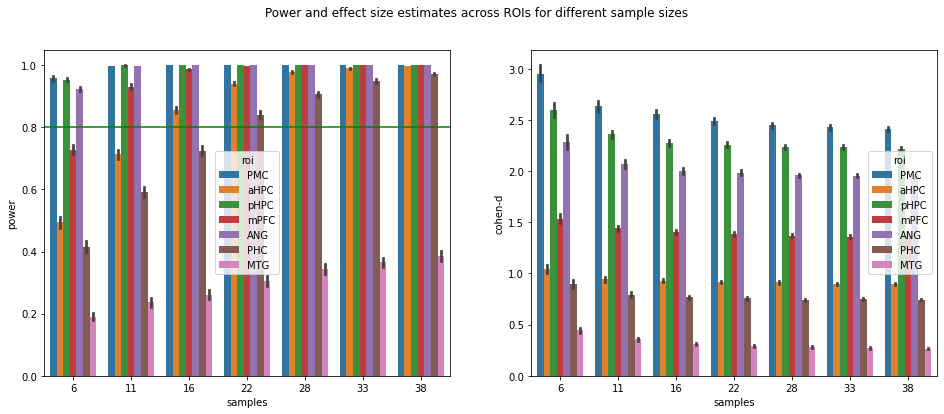

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(ax=ax[0], data=univariate_tt_full, x='samples', y='power', hue='roi')
sns.barplot(ax=ax[1], data=univariate_tt_full, x='samples', y='cohen-d', hue='roi')
ax[0].axhline(0.8, color='g')
fig.suptitle('Power and effect size estimates across ROIs for different sample sizes')

/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


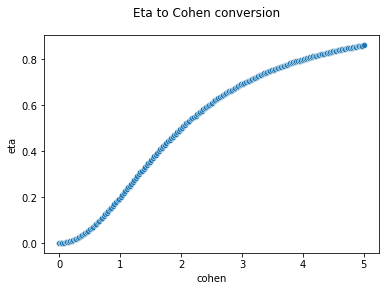

In [117]:
cohens_list = list()
cohens = np.linspace(0,5,200)
for cohen in cohens:
    eta = pg.convert_effsize(cohen, 'cohen', 'eta-square')
    cohens_list.append([eta, cohen])
conversion = pd.DataFrame(cohens_list, columns = ['eta', 'cohen'])
sns.scatterplot(conversion.cohen, conversion.eta)
plt.suptitle('Eta to Cohen conversion')
None

Effect Size: 0.529


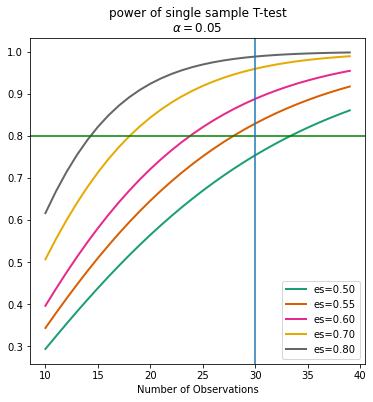

In [114]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1,1)
fig = TTestPower().plot_power(dep_var='nobs',
                              nobs = np.arange(10, 40),
                              effect_size = np.array([0.5, 0.55, 0.6, 0.7, 0.8]),
                              alpha = 0.05,
                              ax=ax, title='power of single sample T-test' + '\n' + r'$\alpha = 0.05$')
plt.axhline(0.8, color = 'g')
plt.axvline(30)
None

# getting example sample size for an expected effect size
effect = 0.6
power = 0.8
alpha = 0.05
power_analysis = TTestPower()
result = power_analysis.solve_power(power=power, nobs=30, alpha=alpha)
print('Effect Size: %.3f' % result)

## Summary of univariate power analysis in adults.
The effect size found in Reagh et al., 2020 is strong and they only needed around 22 participants to see their actual effect of interest across ROIs. Our sample will have 30 participants, even if our effect size is not as strong i.e., 0.55 instead of around 0.8 we would have enough power to see our desired effect in adults.

### Connectivity contrast at event boubdaries between hippocampus and cortical regions of interest
#### Measure: Univariate difference from zero at event boundaries between ROIs for adults - T-test

#### Cooper et al., 2021
The authors here use the same dataset from Reagh et al., 2020, a movie with 19 event boundaries. Below are aggregate connectivity sub-systems across ROIs. This is slightly different from the proposed analysis but still applicable because if the authors find an effect across regions it suggests we will see a similar pattern of results even if they differ by region.

- Ventral PM subsystem 
    - Group 1: mean Z = 0.23, SE = 0.04, t(67) = 6.03, p < .001
    - Group 2: mean Z = 0.20, SE = 0.04, t(67) = 5.45, p < .001 

- Dorsal PM subsystem 
    - Group 1: mean Z = 0.30, SE = 0.05, t(67) = 6.74, p < .001
    - Group 2: mean Z = 0.25, SE = 0.04, t(67) = 5.57, p < .001

In [16]:
# values from Cooper et al., 2021
n_adult = 68
ventral_mean = 0.215
ventral_se = 0.04
ventral_sd = ventral_se * np.sqrt(n_adult)
dorsal_mean = 0.275
dorsal_se = 0.045
dorsal_sd = dorsal_se * np.sqrt(n_adult)

# simulate data points using mean and sd
nsim = 1000
grp = np.repeat(['adult'], n_adult)
vals1 = np.random.normal(ventral_mean, ventral_sd, n_adult)
vals2 = np.random.normal(dorsal_mean, dorsal_sd, n_adult)
df1 = pd.DataFrame([grp, vals1], index=['group', 'values']).T
df2 = pd.DataFrame([grp, vals2], index=['group', 'values']).T
df1['values'] = df1['values'].astype('float') 
df2['values'] = df2['values'].astype('float') 
test_list = list()
for frac in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    for sim in range(nsim):
        sdf1 = df1.sample(frac=frac)
        tt1 = ttest(sdf1.loc[:,'values'].values, 0)
        tt1['rois'] = 'ventral'
        tt1['samples'] = len(sdf1)

        sdf2 = df2.sample(frac=frac)
        tt2 = ttest(sdf2.loc[:,'values'].values, 0)
        tt2['rois'] = 'dorsal'
        tt2['samples'] = len(sdf2)
        test_list.append(tt1)
        test_list.append(tt2)
        
connectivity_tt_full = pd.concat(test_list)

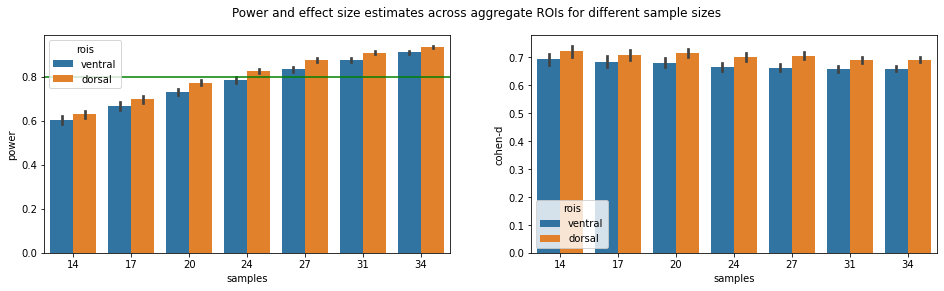

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.barplot(ax=ax[0], data=connectivity_tt_full, x='samples', y='power', hue='rois')
sns.barplot(ax=ax[1], data=connectivity_tt_full, x='samples', y='cohen-d', hue='rois')
fig.suptitle('Power and effect size estimates across aggregate ROIs for different sample sizes')
ax[0].axhline(0.8, color='g')
None

Effect Size: 0.529


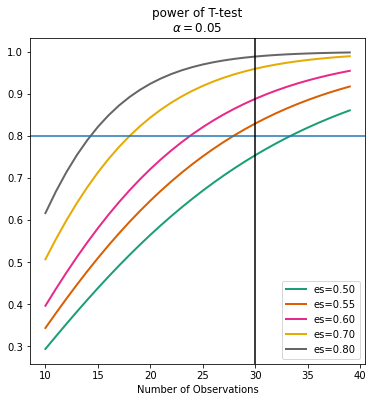

In [118]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1,1)
fig = TTestPower().plot_power(dep_var='nobs',
                              nobs = np.arange(10, 40),
                              effect_size = np.array([0.5, 0.55, 0.6, 0.7, 0.8]),
                              alpha = 0.05,
                              ax=ax, title='power of T-test' + '\n' + r'$\alpha = 0.05$')
plt.axhline(0.8)
plt.axvline(30, color='k')
None
# getting example sample size for an expected effect size
effect = 0.6
power = 0.8
alpha = 0.05
power_analysis = TTestPower()
result = power_analysis.solve_power(power=power, nobs=30, alpha=alpha)
print('Effect Size: %.3f' % result)

## Summary of connectivity power analysis in adults.
The effect size found in Cooper et al., 2020 is strong and the authors only needed around 20 participants to see their actual effect of interest across two 'aggregated' ROIs i.e., 'ventral' and 'dorsal', which are a combination of the ROIs we will be using in our proposed analysis. Our sample will have 30 participants, even if our effect size is not as strong i.e., 0.529 we would still have enough power to see our desired effect in adults.
<br><br><br><br>

# Calculating power developmental differences between adults and childrens univariate and connectivity contrasts.
### Univariate contrast to measure developmental differences in boundary response between samples and across regions of interest (ROI)
#### Measure: Univariate difference between groups at event boundaries across ROIs - Independent samples T-test

#### Golarai et al. 2007
- prenumbra area in posterior place area (ppa) - PHC

In Golarai et al. 2007, the participant breakdown is:
- 10 children, 7-11 years, (average age = ??.??)
- 13 adults, (average age = ??.??)

In [ ]:
n_child = 10
n_adult = 13
phc_file = 'golarai_2008/golarai_prenumbra5_ppa_kid-adult.csv'
full_file = os.path.join(data_dir, phc_file)
n_small_sims = 1000
test_list = list()    
for sim in range(n_small_sims):    
    # calculate effect size
    df = simulate_bar_graph_data(full_file, n_child, n_adult)
    av = anova(data=df, dv='values', between='group')
    effect_size = av.np2[0]

    # other parameters
    power = 0.8
    alpha = 0.05
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                             power = power, 
                                             alpha = alpha)
    av['samples'] = sample_size
    test_list.append(av)
    
dev_diff = pd.concat(test_list)

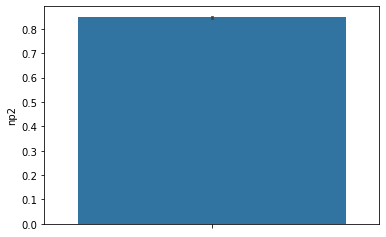

In [42]:
dev_diff
sns.barplot(data=dev_diff, y='np2')
None

#### Ofen et al. 2012
- Values taken from posterior parietal cortex (ppc)

In Ofen et al. 2012, the participant breakdown is:
- 27 children, 7-11 years, (average age = ??.??)
- 32 adults, (average age = ??.??)

Here, the standard deviation is simulated at different levels because it was not provided and could not be deduced from the data points.

In [51]:
uni_adults_PAR = 'ofen_2012_parietal_mem_resp_adults.csv'; uni_kids_PAR = 'ofen_2012_parietal_mem_resp_kids.csv'; uni_ages_PAR = 'ofen_2012_ages.csv'
max_val_kids = pd.read_csv(uni_kids_PAR, header=None).max()[1] # the highest average across time series
max_val_adults = pd.read_csv(uni_adults_PAR, header=None).max()[1] # the highest average across time series
ages = pd.read_csv(uni_ages_PAR, header=None)[1]
tests = list()
kid_sds = np.linspace(0.3, .1, 6)
n_kids = 27
n_adults = 32
nsim = 1000
for sd in kid_sds:
    for sim in range(nsim):
        par_resp = np.hstack([np.random.normal(max_val_kids, sd, n_kids).reshape([1,n_kids]), np.random.normal(max_val_adults, sd, n_adults).reshape([1,n_adults])])
        labels = np.hstack([np.repeat(['kid'], n_kids), np.repeat(['adult'],n_adults)])
        df = pd.DataFrame([par_resp[0], labels]).T
        df.columns = ['parietal resp', 'group']
        df['parietal resp'] = df['parietal resp'].astype('float')
        av = anova(data=df, dv='parietal resp', between='group')
        tests.append(np.array([sd, n_kids, n_adults, av.F[0], av.np2[0]]))

av = pd.DataFrame(tests, columns=['sd', 'N kid','N adult', 'F', 'es'])

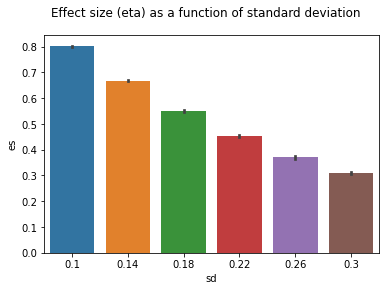

In [102]:
sns.barplot(data=av, x='sd', y='es')
plt.suptitle('Effect size (eta) as a function of standard deviation')
None

Sample Size: 0.534


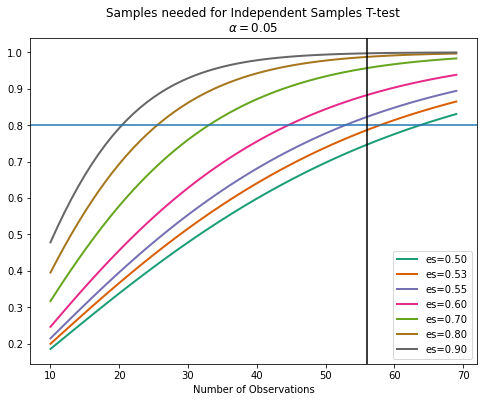

In [116]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs = np.arange(10, 70),
                                 effect_size = np.array([0.5, 0.525, 0.55, 0.6, 0.7, 0.8, 0.9]),
                                 alpha = 0.05,
                                 ax=ax, title='Samples needed for Independent Samples T-test' + '\n' + r'$\alpha = 0.05$')
plt.axhline(0.8)
plt.axvline(56, color='k')
None

# getting example sample size for an expected effect size
effect = 0.55
power = 0.8
alpha = 0.05
power_analysis = TTestIndPower()
result = power_analysis.solve_power(power=power, nobs1=56, alpha=alpha)
print('Sample Size: %.3f' % result)

## Summary of developmental differences in univariate response.
Both studies sampled here found significant results with different sample sizes and effect sizes which suggests the underlying signal that is being sampled is important. As no studies to date have measured developmental differences in event boundaries our adult work suggests we are sufficiently powered to see effects if they exist. The minimum effect size needed in our sample size of 56 would be roughly 0.55. This effect size was exhibited in both Golarai et al., 2007 and Ofen et al., 2012.

# Null effects for developmental differences.

In [ ]:
n_child = 23
n_adult = 18
ppc_file = 'demaster_2013_kids-adults/demaster_2013_left-ppc_kid-adult.csv'
full_file = os.path.join(data_dir, ppc_file)
df = simulate_bar_graph_data(full_file, n_child, n_adult)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1,1)
fig = FTestAnovaPower().plot_power(dep_var='nobs',
                                   nobs = np.arange(10, 100),
                                   effect_size = np.array([0.4, 0.5, 0.6, 0.7,  0.8]),
                                   alpha = 0.05,
                                   ax=ax, title='power of anova' + '\n' + r'$\alpha = 0.05$')
plt.axhline(0.8)
None

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs = np.arange(10, 80),
                                 effect_size = np.array([0.5, 0.525, 0.55, 0.6, 0.7, 0.8, 0.9]),
                                 alpha = 0.05,
                                 ax=ax, title='power of T-test' + '\n' + r'$\alpha = 0.05$')
plt.axhline(0.8)
plt.axvline(56, color='k')
None

# connectivity kids

In [ ]:
conn_kids_HP_PAR = 'conn_ant-PC_child_riggins_etal_2016.csv'
df = pd.read_csv(conn_kids_HP_PAR, header=1)
df.columns = ['episodic', 'antHPC_PC']
df.head()
sns.regplot(x='episodic', y='antHPC_PC', data=df)

# connectivity adults

In [ ]:
import statsmodels.formula.api as smf
conn_adults_HP_PAR = 'conn_PM_adults_cooper_etal_2021.csv'
df = pd.read_csv(conn_adults_HP_PAR, header=None)
df = pd.DataFrame([np.repeat(['adult'],len(df[1].values)), df[1].values]).T
df
# df.columns = ['episodic', 'antHPC_PC']
# df.head()
# sns.regplot(x='episodic', y='antHPC_PC', data=df)